In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [89]:
# Generating random graph
deep_reload(src)

seed = np.random.randint(0, sys.maxsize)
# seed = 758712061200539789
print(seed)

n_nodes = 100
n_chargers = 10
charger_probability = .9
charger_fields = ['length']
charger_amounts = [40]
n_targets = 5

scale = (100, 100)
link_bounds = (1e-6, 25)
link_speeds = [35, 55, 90, 105]

minimum_path_probability = .9

graph = src.graph.random_graph(
    n_nodes,
    scale,
    link_bounds,
    link_speeds,
    seed
)

deep_reload(src)

fields = ['length', 'time']
limits = [40, np.inf]
weights = [1, .5]

objective = src.dijkstra.Objective(fields, limits, weights = weights)

deep_reload(src)

rng = np.random.default_rng(seed)

charger_nodes = rng.choice(graph.nodes, n_chargers, replace = False)

chargers = {
    n: src.dijkstra.Charger(n, charger_fields, charger_amounts, charger_probability) \
    for n in charger_nodes}


target_nodes = rng.choice(graph.nodes, n_targets, replace = False)

4427517364088133866


In [97]:
deep_reload(src)

def tim_fun():
    path_values, _ = src.dijkstra.dijkstra(
        graph, [source_node], objective,
        targets = target_nodes, chargers = chargers,
        minimum_path_probability = minimum_path_probability)
%timeit tim_fun()

1.9 ms ± 5.49 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


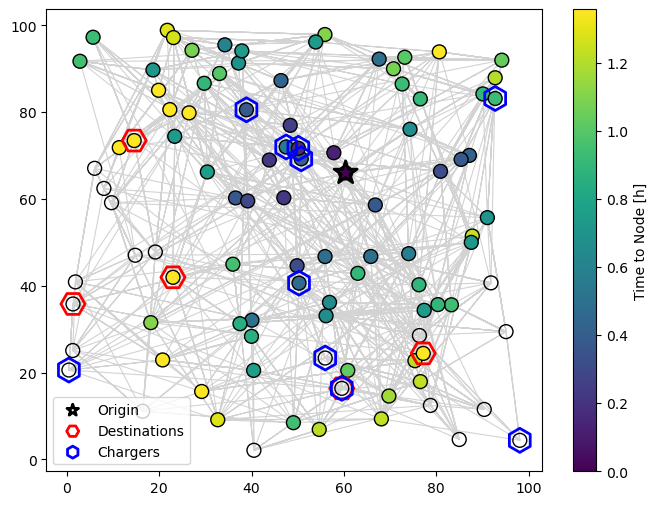

In [94]:
deep_reload(src)

fig = src.figures.dijkstra_output(
    graph, path_values, [source_node], target_nodes, chargers)